# SETUP (ทำทุกครั้งหลังจากเปิด)

ห้ามเอา API ออกเป็นอันขาด

In [ ]:
#install modules
!pip install tweepy
!pip install gspread==5.2.0
!pip install emoji
!pip install dostoevsky
!pip install sklearn
!pip install wordcloud
!pip install pyLDAvis
!python -m dostoevsky download fasttext-social-network-model
!pip install git+https://github.com/rwalk/gsdmm.git
!pip install numpy
!pip install pymorphy2

  Attempting uninstall: gspread
    Found existing installation: gspread 3.4.2
    Uninstalling gspread-3.4.2:
      Successfully uninstalled gspread-3.4.2
     |████████████████████████████████| 175 kB 4.9 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=58ee4508cec736207fb0682cddabf611acc82c9562b67473dea9831d59bb6913
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
     |████████████████████████████████| 68 kB 2.2 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3142208 sha256=e8aa9f93b3a74b1a09741d00bc25c702895af172e4e84993e29ce7cde0b4372b
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext
     |████████████████████████████████| 1.7 MB 4.9 MB/s 
  Installing build dependencies

In [ ]:
# import libraries
from tqdm import tqdm
import emoji
import re
import tweepy as tw
import pandas as pd
import numpy as np
from datetime import datetime
import gspread as gs
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint
import os
from gsdmm import MovieGroupProcess
import pymorphy2
import pyLDAvis.gensim_models as gensimvis
import pickle
import pyLDAvis

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
# twitter authentication
consumer_key = ''
consumer_secret = ''
access_token = ''
access_token_secret = ''

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [ ]:
# check rate limit
print("Rate Limit: "+str(api.rate_limit_status()['resources']['search']['/search/tweets']['remaining'])+"/180")
print("Next Scrape Reset: "+str(datetime.fromtimestamp(api.rate_limit_status()['resources']['search']['/search/tweets']['reset']))+" GMT+0")

Rate Limit: 180/180
Next Scrape Reset: 2022-04-17 02:20:19 GMT+0


# SCRAPE (PHASE 1)

ขูดข้อมูลจาก Twitter

เซ็ต parameter อะไรได้เองเลย

กด Run ผลลัพธ์เข้า Google Sheets


In [ ]:
# DATAFRAME
df = pd.DataFrame(columns=['Date','Query','User','Tweet'])

In [ ]:
# PARAMETERS (อยากได้อะไร กำหนดเองได้เลย)
# do not forget that there's a rate limit, check setup page.
search_words = ['вайб','бейзд','байтить','хейтить','краш','абобус','бумер','фудпорн','агриться','миллениалы','нуб','шмот','жиза','варик','дичь','паль','зашквар','кекать']
language = 'ru'
date_since = "2022-03-16"
date_until = "2022-03-17"
count = 1000

credential_path = '/content/drive/MyDrive/testname-310302-64c4abdb818d.json' # request credentials from Google
worksheet_name = 'RUSSIAN SLANGS DATASET'

In [ ]:
# DEFINE FUNCTION

removeRetweet = re.compile(r'(RT\s\@\w+\:\s?|\@\w+\s?)')
removeURL = re.compile(r'http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
removeBackSlash = re.compile(r'(\\n|\\r|\\(u|U)\w{1,8})')
detectWhiteSpace = re.compile(r'\s{2,}')

def deEmoji(text):
    return emoji.get_emoji_regexp().sub(r'', text)

def clean(text):
  return deEmoji(detectWhiteSpace.sub(' ', removeBackSlash.sub('', removeURL.sub('', removeRetweet.sub('', text))))).lower().strip()

In [ ]:
%%time

# Collect tweets
for word in search_words:
  print('\n')
  print('Current Word: '+word)
  print('Date: '+date_since+" to "+date_until)
  print("Rate Limit: "+str(api.rate_limit_status()['resources']['search']['/search/tweets']['remaining'])+"/180")
  tweets = tw.Cursor(api.search,
                q=word,
                lang=language,
                until=date_until,
                since=date_since).items(count)

  data = [[tweet.created_at.strftime("%Y-%m-%d %H:%M:%S"), word, tweet.user.screen_name, tweet.text] for tweet in tweets]

  # Append to Dataframe
  for datum in tqdm(data):
    df.loc[len(df)] = datum

# Clean Tweets
tweet_list_clean = []
for tweet in df['Tweet'].to_list():
  tweet_list_clean.append(clean(tweet))

# Add new column to Dataframe
df['Cleaned Tweet'] = tweet_list_clean

# Append Dataframe to Spreadsheet
gs.service_account(filename=credential_path).open(worksheet_name).get_worksheet(0).append_rows(df.values.tolist())



Current Word: вайб
Date: 2022-03-16 to 2022-03-17
Rate Limit: 180/180


100%|██████████| 372/372 [00:00<00:00, 406.65it/s]




Current Word: бейзд
Date: 2022-03-16 to 2022-03-17
Rate Limit: 154/180


100%|██████████| 1/1 [00:00<00:00, 210.17it/s]




Current Word: байтить
Date: 2022-03-16 to 2022-03-17
Rate Limit: 152/180


100%|██████████| 4/4 [00:00<00:00, 349.27it/s]




Current Word: хейтить
Date: 2022-03-16 to 2022-03-17
Rate Limit: 150/180


100%|██████████| 58/58 [00:00<00:00, 149.89it/s]




Current Word: краш
Date: 2022-03-16 to 2022-03-17
Rate Limit: 145/180


100%|██████████| 263/263 [00:01<00:00, 185.31it/s]




Current Word: абобус
Date: 2022-03-16 to 2022-03-17
Rate Limit: 126/180


100%|██████████| 2/2 [00:00<00:00, 113.58it/s]




Current Word: бумер
Date: 2022-03-16 to 2022-03-17
Rate Limit: 124/180


100%|██████████| 8/8 [00:00<00:00, 100.62it/s]




Current Word: фудпорн
Date: 2022-03-16 to 2022-03-17
Rate Limit: 122/180


100%|██████████| 1/1 [00:00<00:00, 144.90it/s]




Current Word: агриться
Date: 2022-03-16 to 2022-03-17
Rate Limit: 120/180


100%|██████████| 8/8 [00:00<00:00, 84.20it/s]




Current Word: миллениалы
Date: 2022-03-16 to 2022-03-17
Rate Limit: 118/180


100%|██████████| 14/14 [00:00<00:00, 120.77it/s]




Current Word: нуб
Date: 2022-03-16 to 2022-03-17
Rate Limit: 116/180


100%|██████████| 10/10 [00:00<00:00, 392.91it/s]




Current Word: шмот
Date: 2022-03-16 to 2022-03-17
Rate Limit: 114/180


100%|██████████| 20/20 [00:00<00:00, 410.08it/s]




Current Word: жиза
Date: 2022-03-16 to 2022-03-17
Rate Limit: 111/180


100%|██████████| 880/880 [00:02<00:00, 402.72it/s]




Current Word: варик
Date: 2022-03-16 to 2022-03-17
Rate Limit: 51/180


100%|██████████| 41/41 [00:00<00:00, 384.16it/s]




Current Word: дичь
Date: 2022-03-16 to 2022-03-17
Rate Limit: 47/180


100%|██████████| 332/332 [00:00<00:00, 412.87it/s]




Current Word: паль
Date: 2022-03-16 to 2022-03-17
Rate Limit: 23/180


100%|██████████| 2/2 [00:00<00:00, 265.58it/s]




Current Word: зашквар
Date: 2022-03-16 to 2022-03-17
Rate Limit: 21/180


100%|██████████| 38/38 [00:00<00:00, 400.88it/s]




Current Word: кекать
Date: 2022-03-16 to 2022-03-17
Rate Limit: 17/180


100%|██████████| 3/3 [00:00<00:00, 286.65it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  if __name__ == '__main__':


CPU times: user 10.3 s, sys: 329 ms, total: 10.6 s
Wall time: 55.2 s


In [ ]:
# Dataframe
df

,Date,Query,User,Tweet,Cleaned Tweet
0,2022-03-16 23:45:07,вайб,evildoggi,RT @A_Yuzhakov: Смелая конгрессвумен-республик...,смелая конгрессвумен-республиканка маржори гри...
1,2022-03-16 23:31:28,вайб,walkers_diary,@virtuous_fox мне нравятся кинны ваньнина\nещё...,"мне нравятся кинны ваньнина\nещё не поняла, я ..."
2,2022-03-16 23:24:16,вайб,travneva_,@jegdorothea це все вайб,це все вайб
3,2022-03-16 23:21:48,вайб,zhaoyourlan,RT @jislunar: сынмину признал что у него есть ...,сынмину признал что у него есть этот вайб чьей...
4,2022-03-16 23:15:10,вайб,ayaka00062,RT @A_Yuzhakov: Смелая конгрессвумен-республик...,смелая конгрессвумен-республиканка маржори гри...
...,...,...,...,...,...
2052,2022-03-16 04:03:09,зашквар,BISMARK_TV,это же зашквар от шойгу получать значки?\nПо с...,это же зашквар от шойгу получать значки?\nпо с...
2053,2022-03-16 01:24:01,зашквар,noop_dev,@ilya_nuzov @Kasparov63 @vkaramurza @sguriev З...,зашквар для каспарова конечно быть в компании ...
2054,2022-03-16 18:12:19,кекать,thorn_crumble,@michaelidov щас мы тут в России все кекать бу...,"щас мы тут в россии все кекать будем, чтобы де..."
2055,2022-03-16 18:04:19,кекать,Oridzuru_fk,"@A9niBearn Я сначала Рогозину смерти, а потом ...","я сначала рогозину смерти, а потом поняла, что..."


#SENTIMENTAL ANALYSIS (PHASE 2)

In [ ]:
# PARAMETERS

credential_path = '/content/drive/MyDrive/testname-310302-64c4abdb818d.json' # request credentials from Google
worksheet_name = 'RUSSIAN SLANGS DATASET'

In [ ]:
# CREATE DATAFRAME FROM SHEET 0

table = gs.service_account(filename=credential_path).open(worksheet_name).get_worksheet(0).get_all_values()
headers = table.pop(0)
df = pd.DataFrame(table, columns=headers)

In [ ]:
df

,Date,Query,User,Tweet,Cleaned Tweet
0,2022-03-04 23:59:01,вайб,pingvinkakaet,@kikikihuu блять у этого мема вообще какой-то ...,блять у этого мема вообще какой-то странный ва...
1,2022-03-04 23:51:44,вайб,simorte777,Балканский вайб https://t.co/xBLlaHOGb2,балканский вайб
2,2022-03-04 22:54:43,вайб,evelistina,илья у антона с дрейком выпивший или мне кажет...,илья у антона с дрейком выпивший или мне кажет...
3,2022-03-04 22:44:54,вайб,somesay3,"Недавно услышала в свою сторону, что джуси инс...","недавно услышала в свою сторону, что джуси инс..."
4,2022-03-04 22:17:47,вайб,whowillprayfor,вайб тебе если мои условия не нравятся блять т...,вайб тебе если мои условия не нравятся блять т...
...,...,...,...,...,...
29658,2022-03-16 04:03:09,зашквар,BISMARK_TV,это же зашквар от шойгу получать значки?\nПо с...,это же зашквар от шойгу получать значки?\nпо с...
29659,2022-03-16 01:24:01,зашквар,noop_dev,@ilya_nuzov @Kasparov63 @vkaramurza @sguriev З...,зашквар для каспарова конечно быть в компании ...
29660,2022-03-16 18:12:19,кекать,thorn_crumble,@michaelidov щас мы тут в России все кекать бу...,"щас мы тут в россии все кекать будем, чтобы де..."
29661,2022-03-16 18:04:19,кекать,Oridzuru_fk,"@A9niBearn Я сначала Рогозину смерти, а потом ...","я сначала рогозину смерти, а потом поняла, что..."


In [ ]:
# REMOVE "DUPLICATES" IN DATAFRAME

table_nodupe = [['Date','Query','User','Tweet','Cleaned Tweet']]
for data in table:
  if data[3] != table_nodupe[len(table_nodupe)-1][3]:
    table_nodupe.append(data)

headers_nodupe = table_nodupe.pop(0)
df_nodupe = pd.DataFrame(table_nodupe, columns=headers_nodupe)

In [ ]:
# SENTIMENT ANALYSIS

# Tokenizer
tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

# Prediction
messages = list(df_nodupe["Cleaned Tweet"])
results = model.predict(messages, k=1)

# Append Results to Dataframe
sentiments = []
values = []
for result in results:
  sentiments.append(list(result.items())[0][0])
  values.append(list(result.items())[0][1])
df_nodupe["Sentiment"]=sentiments
df_nodupe["Value"]=values

# Append Dataframe to Spreadsheet
gs.service_account(filename=credential_path).open(worksheet_name).get_worksheet(1).append_rows(df_nodupe.values.tolist())

{'spreadsheetId': '18Clj0GrDOrJ57uD7zRrVtMxfxuEvrl05QAdZzJsIgnw',
 'tableRange': 'Sheet2!A1:G1',
 'updates': {'spreadsheetId': '18Clj0GrDOrJ57uD7zRrVtMxfxuEvrl05QAdZzJsIgnw',
  'updatedCells': 187950,
  'updatedColumns': 7,
  'updatedRange': 'Sheet2!A2:G26851',
  'updatedRows': 26850}}

In [ ]:
df_nodupe

,Date,Query,User,Tweet,Cleaned Tweet,Sentiment,Value
0,2022-03-04 23:59:01,вайб,pingvinkakaet,@kikikihuu блять у этого мема вообще какой-то ...,блять у этого мема вообще какой-то странный ва...,negative,0.874087
1,2022-03-04 23:51:44,вайб,simorte777,Балканский вайб https://t.co/xBLlaHOGb2,балканский вайб,neutral,0.999364
2,2022-03-04 22:54:43,вайб,evelistina,илья у антона с дрейком выпивший или мне кажет...,илья у антона с дрейком выпивший или мне кажет...,neutral,0.327678
3,2022-03-04 22:44:54,вайб,somesay3,"Недавно услышала в свою сторону, что джуси инс...","недавно услышала в свою сторону, что джуси инс...",neutral,0.245095
4,2022-03-04 22:17:47,вайб,whowillprayfor,вайб тебе если мои условия не нравятся блять т...,вайб тебе если мои условия не нравятся блять т...,neutral,0.392347
...,...,...,...,...,...,...,...
26845,2022-03-16 04:03:09,зашквар,BISMARK_TV,это же зашквар от шойгу получать значки?\nПо с...,это же зашквар от шойгу получать значки?\nпо с...,neutral,0.484390
26846,2022-03-16 01:24:01,зашквар,noop_dev,@ilya_nuzov @Kasparov63 @vkaramurza @sguriev З...,зашквар для каспарова конечно быть в компании ...,neutral,0.754925
26847,2022-03-16 18:12:19,кекать,thorn_crumble,@michaelidov щас мы тут в России все кекать бу...,"щас мы тут в россии все кекать будем, чтобы де...",negative,0.507822
26848,2022-03-16 18:04:19,кекать,Oridzuru_fk,"@A9niBearn Я сначала Рогозину смерти, а потом ...","я сначала рогозину смерти, а потом поняла, что...",neutral,0.500010


# LDA TOPIC MODELLING (PHASE 3)

Results are wack. ~~Try GSDMM (Gibbs Sampling Dirichlet Multinomial Mixture)~~

NLTK Stopwords are bad, Using manual list.

Much better

Todo: Lemmatize

['вайб','бейзд','байтить','хейтить','краш','абобус','бумер','фудпорн','агриться','миллениалы','нуб','шмот','жиза','варик','дичь','паль','зашквар','кекать']


In [ ]:
# PARAMETERS (อยากได้อะไร กำหนดเองได้เลย)

credential_path = '/content/drive/MyDrive/testname-310302-64c4abdb818d.json' # request credentials from Google
worksheet_name = 'RUSSIAN SLANGS DATASET'

In [ ]:
# CREATE DATAFRAME FROM SHEET 1

table = gs.service_account(filename=credential_path).open(worksheet_name).get_worksheet(1).get_all_values()
headers = table.pop(0)
df = pd.DataFrame(table, columns=headers)

In [ ]:
df = df.drop(columns=['Date','User','Tweet','Sentiment','Value'])

In [ ]:
df

,Query,Cleaned Tweet
0,вайб,блять у этого мема вообще какой-то странный ва...
1,вайб,балканский вайб
2,вайб,илья у антона с дрейком выпивший или мне кажет...
3,вайб,"недавно услышала в свою сторону, что джуси инс..."
4,вайб,вайб тебе если мои условия не нравятся блять т...
...,...,...
26845,зашквар,это же зашквар от шойгу получать значки?\nпо с...
26846,зашквар,зашквар для каспарова конечно быть в компании ...
26847,кекать,"щас мы тут в россии все кекать будем, чтобы де..."
26848,кекать,"я сначала рогозину смерти, а потом поняла, что..."


In [ ]:
# TEST DRIVE LDA

query = "хейтить"
testdf = df[df['Query'] == query]

stop_words = ["c", "а", "алло", "без", "белый", "близко", "более", "больше", "большой", "будем", "будет", "будете", "будешь", "будто", "буду", "будут", "будь", "бы", "бывает", "бывь", "был", "была", "были", "было", "быть", "в", "важная", "важное", "важные", "важный", "вам", "вами", "вас", "ваш", "ваша", "ваше", "ваши", "вверх", "вдали", "вдруг", "ведь", "везде", "вернуться", "весь", "вечер", "взгляд", "взять", "вид", "видел", "видеть", "вместе", "вне", "вниз", "внизу", "во", "вода", "война", "вокруг", "вон", "вообще", "вопрос", "восемнадцатый", "восемнадцать", "восемь", "восьмой", "вот", "впрочем", "времени", "время", "все", "все еще", "всегда", "всего", "всем", "всеми", "всему", "всех", "всею", "всю", "всюду", "вся", "всё", "второй", "вы", "выйти", "г", "где", "главный", "глаз", "говорил", "говорит", "говорить", "год", "года", "году", "голова", "голос", "город", "да", "давать", "давно", "даже", "далекий", "далеко", "дальше", "даром", "дать", "два", "двадцатый", "двадцать", "две", "двенадцатый", "двенадцать", "дверь", "двух", "девятнадцатый", "девятнадцать", "девятый", "девять", "действительно", "дел", "делал", "делать", "делаю", "дело", "день", "деньги", "десятый", "десять", "для", "до", "довольно", "долго", "должен", "должно", "должный", "дом", "дорога", "друг", "другая", "другие", "других", "друго", "другое", "другой", "думать", "душа", "е", "его", "ее", "ей", "ему", "если", "есть", "еще", "ещё", "ею", "её", "ж", "ждать", "же", "жена", "женщина", "жизнь", "жить", "за", "занят", "занята", "занято", "заняты", "затем", "зато", "зачем", "здесь", "земля", "знать", "значит", "значить", "и", "иди", "идти", "из", "или", "им", "имеет", "имел", "именно", "иметь", "ими", "имя", "иногда", "их", "к", "каждая", "каждое", "каждые", "каждый", "кажется", "казаться", "как", "какая", "какой", "кем", "книга", "когда", "кого", "ком", "комната", "кому", "конец", "конечно", "которая", "которого", "которой", "которые", "который", "которых", "кроме", "кругом", "кто", "куда", "лежать", "лет", "ли", "лицо", "лишь", "лучше", "любить", "люди", "м", "маленький", "мало", "мать", "машина", "между", "меля", "менее", "меньше", "меня", "место", "миллионов", "мимо", "минута", "мир", "мира", "мне", "много", "многочисленная", "многочисленное", "многочисленные", "многочисленный", "мной", "мною", "мог", "могу", "могут", "мож", "может", "может быть", "можно", "можхо", "мои", "мой", "мор", "москва", "мочь", "моя", "моё", "мы", "на", "наверху", "над", "надо", "назад", "наиболее", "найти", "наконец", "нам", "нами", "народ", "нас", "начала", "начать", "наш", "наша", "наше", "наши", "не", "него", "недавно", "недалеко", "нее", "ней", "некоторый", "нельзя", "нем", "немного", "нему", "непрерывно", "нередко", "несколько", "нет", "нею", "неё", "ни", "нибудь", "ниже", "низко", "никакой", "никогда", "никто", "никуда", "ним", "ними", "них", "ничего", "ничто", "но", "новый", "нога", "ночь", "ну", "нужно", "нужный", "нх", "о", "об", "оба", "обычно", "один", "одиннадцатый", "одиннадцать", "однажды", "однако", "одного", "одной", "оказаться", "окно", "около", "он", "она", "они", "оно", "опять", "особенно", "остаться", "от", "ответить", "отец", "откуда", "отовсюду", "отсюда", "очень", "первый", "перед", "писать", "плечо", "по", "под", "подойди", "подумать", "пожалуйста", "позже", "пойти", "пока", "пол", "получить", "помнить", "понимать", "понять", "пор", "пора", "после", "последний", "посмотреть", "посреди", "потом", "потому", "почему", "почти", "правда", "прекрасно", "при", "про", "просто", "против", "процентов", "путь", "пятнадцатый", "пятнадцать", "пятый", "пять", "работа", "работать", "раз", "разве", "рано", "раньше", "ребенок", "решить", "россия", "рука", "русский", "ряд", "рядом", "с", "с кем", "сам", "сама", "сами", "самим", "самими", "самих", "само", "самого", "самой", "самом", "самому", "саму", "самый", "свет", "свое", "своего", "своей", "свои", "своих", "свой", "свою", "сделать", "сеаой", "себе", "себя", "сегодня", "седьмой", "сейчас", "семнадцатый", "семнадцать", "семь", "сидеть", "сила", "сих", "сказал", "сказала", "сказать", "сколько", "слишком", "слово", "случай", "смотреть", "сначала", "снова", "со", "собой", "собою", "советский", "совсем", "спасибо", "спросить", "сразу", "стал", "старый", "стать", "стол", "сторона", "стоять", "страна", "суть", "считать", "т", "та", "так", "такая", "также", "таки", "такие", "такое", "такой", "там", "твои", "твой", "твоя", "твоё", "те", "тебе", "тебя", "тем", "теми", "теперь", "тех", "то", "тобой", "тобою", "товарищ", "тогда", "того", "тоже", "только", "том", "тому", "тот", "тою", "третий", "три", "тринадцатый", "тринадцать", "ту", "туда", "тут", "ты", "тысяч", "у", "увидеть", "уж", "уже", "улица", "уметь", "утро", "хороший", "хорошо", "хотел бы", "хотеть", "хоть", "хотя", "хочешь", "час", "часто", "часть", "чаще", "чего", "человек", "чем", "чему", "через", "четвертый", "четыре", "четырнадцатый", "четырнадцать", "что", "чтоб", "чтобы", "чуть", "шестнадцатый", "шестнадцать", "шестой", "шесть", "эта", "эти", "этим", "этими", "этих", "это", "этого", "этой", "этом", "этому", "этот", "эту", "я", "являюсь",]
stop_words.extend([query])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]
def lemma(texts):
  morph = pymorphy2.MorphAnalyzer()
  return [[morph.parse(word)[0].normal_form for word in doc] for doc in texts]

data = testdf['Cleaned Tweet'].values.tolist()
data_words = list(sent_to_words(data))

data_words = lemma(remove_stopwords(data_words))

/usr/local/lib/python3.7/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.7/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.7/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.7/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.g

In [ ]:
print(data_words[0])

['думать', 'кончиться', 'скоро', 'узнать', 'перевернуть', 'мировоззрение', 'начать', 'возвращаться', 'круг', 'св']


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


In [ ]:
# number of topics
num_topics = 3
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

[(0,
  '0.044*"хеитить" + 0.023*"день" + 0.012*"другой" + 0.011*"шивон" + '
  '0.011*"влияние" + 0.011*"либо" + 0.011*"кпоп" + 0.011*"запомнить" + '
  '0.010*"использовать" + 0.009*"начать"'),
 (1,
  '0.044*"хеитить" + 0.008*"русский" + 0.008*"поддерживать" + 0.006*"мид" + '
  '0.005*"болгария" + 0.005*"всячески" + 0.005*"людея" + 0.005*"призвать" + '
  '0.005*"один" + 0.005*"сеичас"'),
 (2,
  '0.096*"хеитить" + 0.018*"русский" + 0.011*"страна" + 0.007*"разный" + '
  '0.007*"россия" + 0.007*"перестать" + 0.007*"просить" + 0.007*"жителей" + '
  '0.006*"обычный" + 0.006*"мир"')]


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./'+str(num_topics)+'_'+query)
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './'+ str(num_topics)+'_'+query +'.html')
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x        y  topics  cluster       Freq
topic                                               
2     -0.103548 -0.01015       1        1  49.614475
0      0.063740 -0.06080       2        1  26.320509
1      0.039808  0.07095       3        1  24.065016, topic_info=             Term       Freq      Total Category  logprob  loglift
300          день  38.000000  38.000000  Default  30.0000  30.0000
259        другой  21.000000  21.000000  Default  29.0000  29.0000
445         шивон  18.000000  18.000000  Default  28.0000  28.0000
440       влияние  18.000000  18.000000  Default  27.0000  27.0000
443          кпоп  18.000000  18.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
259        другой   4.916753  21.659411   Topic3  -5.5363  -0.0584
442  использовать   4.284657  19.724481   Topic3  -5.6739  -0.1024
444          либо   4.268143  20.405217   Topic3  -5.6777  -0.1402
441     запомнить   3.730607  18.976956   Topic3  -5.8124  -0.2022
443          кпоп   3.684094  18.970671   Topic3  -5.8249  -0.2145

[181 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1309      1  0.182568       gt
1309      2  0.182568       gt
1309      3  0.730273       gt
360       2  0.731208  аккаунт
325       2  0.970449  ахуесть
...     ...       ...      ...
445       2  0.790036    шивон
445       3  0.158007    шивон
508       1  0.134289     этой
508       2  0.268579     этой
508       3  0.671446     этой

[235 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

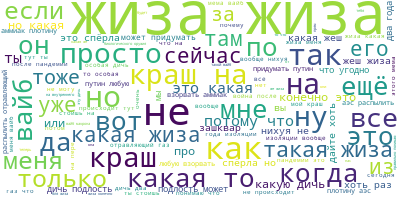

In [ ]:
# WORDCLOUD VISUALIZATION

# Join the different processed titles together.
long_string = ','.join(list(df['Cleaned Tweet'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

# GSDMM TOPIC MODELLING (PHASE 3.1)

Trying GSDMM

In [ ]:
# PARAMETERS

credential_path = '/content/drive/MyDrive/testname-310302-64c4abdb818d.json' # request credentials from Google
worksheet_name = 'RUSSIAN SLANGS DATASET'

In [ ]:
# CREATE DATAFRAME FROM SHEET 1

table = gs.service_account(filename=credential_path).open(worksheet_name).get_worksheet(1).get_all_values()
headers = table.pop(0)
df = pd.DataFrame(table, columns=headers)

In [ ]:
df = df.drop(columns=['Date','User','Tweet','Sentiment','Value'])

In [ ]:
df['tweet_text'] = [tweet.split() for tweet in df["Cleaned Tweet"].to_list()]

In [ ]:
df

,Query,Cleaned Tweet,tweet_text
0,вайб,блять у этого мема вообще какой-то странный ва...,"[блять, у, этого, мема, вообще, какой-то, стра..."
1,вайб,балканский вайб,"[балканский, вайб]"
2,вайб,илья у антона с дрейком выпивший или мне кажет...,"[илья, у, антона, с, дрейком, выпивший, или, м..."
3,вайб,"недавно услышала в свою сторону, что джуси инс...","[недавно, услышала, в, свою, сторону,, что, дж..."
4,вайб,вайб тебе если мои условия не нравятся блять т...,"[вайб, тебе, если, мои, условия, не, нравятся,..."
...,...,...,...
26845,зашквар,это же зашквар от шойгу получать значки?\nпо с...,"[это, же, зашквар, от, шойгу, получать, значки..."
26846,зашквар,зашквар для каспарова конечно быть в компании ...,"[зашквар, для, каспарова, конечно, быть, в, ко..."
26847,кекать,"щас мы тут в россии все кекать будем, чтобы де...","[щас, мы, тут, в, россии, все, кекать, будем,,..."
26848,кекать,"я сначала рогозину смерти, а потом поняла, что...","[я, сначала, рогозину, смерти,, а, потом, поня..."


In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import gensim
from gensim import corpora, models

# cast tweets to numpy array
docs = df.tweet_text.to_numpy()

# create dictionary of all words in all documents
dictionary = gensim.corpora.Dictionary(docs)

# filter extreme cases out of dictionary
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# create BOW dictionary
bow_corpus = [dictionary.doc2bow(doc) for doc in docs]

# create LDA model using preferred hyperparameters
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                         num_topics=5,
                                         id2word=dictionary,
                                         passes=4,
                                         workers=2,
                                         random_state=21)

# Save LDA model to disk
path_to_model = "./"
lda_model.save(path_to_model)

# for each topic, print words occuring in that topic
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

FileNotFoundError: ignored

In [ ]:
print(dictionary)

Dictionary(1515 unique tokens: ['блять', 'вайб', 'вообще', 'какой-то', 'мема']...)


In [ ]:
# print number of documents per topic
doc_count = np.array(gsdmm.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-15:][::-1]
print('Most important clusters (by number of docs inside):', top_index)

# define function to get top words per topic
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts = sorted(cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster, sort_dicts))

# get top words in topics
top_words(gsdmm.cluster_word_distribution, top_index, 20)

Number of documents per topic : [ 593 1178  556 2590  999 2335 1307 1511 1198  825 1435 1483 2121  706
 8013]
Most important clusters (by number of docs inside): [14  3  5 12  7 11 10  6  8  1  4  9 13  0  2]

Cluster 14 : [('жиза', 6506), ('какая', 792), ('я', 556), ('это', 533), ('но', 446), ('жиза.', 445), ('конечно,', 321), ('спёрла,', 311), ('жеш', 311), ('не', 301), ('такая', 289), ('же', 203), ('блять', 173), ('бля', 162), ('и', 155), ('жиза,', 138), ('если', 128), ('у', 124), ('жиза...', 123), ('дичь', 121)]

Cluster 3 : [('я', 1192), ('жиза', 1150), ('и', 784), ('не', 773), ('в', 675), ('жиза,', 577), ('что', 476), ('меня', 469), ('у', 431), ('на', 427), ('с', 393), ('а', 369), ('но', 340), ('так', 283), ('это', 249), ('как', 231), ('только', 226), ('жиза.', 223), ('тоже', 220), ('мне', 211)]

Cluster 5 : [('краш', 1695), ('на', 701), ('я', 622), ('у', 446), ('и', 394), ('в', 385), ('что', 328), ('не', 323), ('мой', 298), ('меня', 271), ('а', 224), ('с', 216), ('он', 203), ('в

In [ ]:
type(docs)

numpy.ndarray

In [ ]:
docs

array(['блять у этого мема вообще какой-то странный вайб хомячек',
       'балканский вайб',
       'илья у антона с дрейком выпивший или мне кажется? сидит в любви всем признается, такой комфорт вайб',
       ...,
       'щас мы тут в россии все кекать будем, чтобы деду сохранить лицо :(',
       'я сначала рогозину смерти, а потом поняла, что душевнобольному желать смерти - это негуманно.\nда еще с кого можно так кекать?',
       'если да, то надеюсь, что я её не увижу. я сюда приходу кекать с дантеса, а не вот это вот всё. порева…'],
      dtype=object)

# TEST PLAYGROUND

In [ ]:
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

tokenizer = RegexTokenizer()

model = FastTextSocialNetworkModel(tokenizer=tokenizer)

messages = [
    'привет',
    'я люблю тебя!!',
    'малолетние дебилы'
]

results = model.predict(messages, k=2)

for message, sentiment in zip(messages, results):
    print(message, '->', sentiment)

    # привет -> {'speech': 1.0000100135803223, 'skip': 0.0020607432816177607}
    # люблю тебя!! -> {'positive': 0.9886782765388489, 'skip': 0.005394937004894018}
    # малолетние дебилы -> {'negative': 0.9525841474533081, 'neutral': 0.13661839067935944}